# Demo 2 - Image Colourization (ChromaGAN)



In [ ]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from keras.layers import BatchNormalization,LeakyReLU,Flatten
from keras.layers import Conv2DTranspose as Deconv2d
from keras.models import Model
from tensorflow.keras.optimizers import Adam

from google.colab import files
from keras import backend as K
import smtplib

from sklearn.utils import shuffle
from google.colab import drive

In [ ]:
def plot(A,B,C,n):

    samples = [A,B,C]
    fig = plt.figure(figsize=(3,n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(3):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32))
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [ ]:
#para plotar duas imagens no caso

def ploty(A,B,n):

    samples = [A,B]
    fig = plt.figure(figsize=(3,n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(2):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32, 1))
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [ ]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y=x_train
x=np.sum(y, axis=3)/(3*255)

y_test=x_test
x_test=np.sum(x_test, axis=3)/(3*255)   #para converter RGB em canal único
x_test=x_test.reshape(10000, 32, 32, 1)


y=x_train/255
y=y*2-1


#x=x*2-1
#x=np.dot(y[...,:3], [0.299, 0.587, 0.114])/255
#x=x.reshape(50000,32, 32,1)

x=x.reshape(50000, 32, 32, 1)

print(x.shape)
print(y.shape)


170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 1)
(50000, 32, 32, 3)


In [ ]:

x_shape=(32,32,1)
y_shape=(32,32,3)

In [ ]:
def Generator():
  X = Input(shape = x_shape)

  #C1 = ZeroPadding2D(padding=(1,1))(X)
  C1 = Conv2D(64,kernel_size = 1, strides = 1,input_shape = x_shape)(X)
  C1 = LeakyReLU(0.2)(C1)

  C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)
  C2 = LeakyReLU(0.2)(C2)

  C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
  C3 = LeakyReLU(0.2)(C3)

  C4 = Conv2D(512,kernel_size = 2, strides = 2)(C3)
  C4 = LeakyReLU(0.2)(C4)

  C5 = Conv2D(512, kernel_size = 2, strides = 2)(C4)
  C5 = LeakyReLU(0.2)(C5)


  DC0 = Deconv2d(512, kernel_size = 2, strides = 2)(C5)
  DC0 = LeakyReLU(0.2)(DC0)
  DC0 = BatchNormalization()(DC0)
  DC0 = Dropout(0.5)(DC0)
  DC0 = Concatenate(axis=3)([DC0, C4])


  DC1 = Deconv2d(256,kernel_size=2, strides = 2)(DC0)
  DC1 = LeakyReLU(0.2)(DC1)
  DC1 = BatchNormalization()(DC1)
  DC1 = Dropout(0.5)(DC1)
  DC1 = Concatenate(axis=3)([DC1,C3])


  DC2 = Deconv2d(128,kernel_size=2, strides = 2)(DC1)
  DC2 = LeakyReLU(0.2)(DC2)
  DC2 = BatchNormalization()(DC2)
  DC2 = Concatenate(axis=3)([DC2,C2])

  DC3 = Deconv2d(64,kernel_size=2, strides = 2)(DC2)
  DC3 = LeakyReLU(0.2)(DC3)
  DC3 = BatchNormalization()(DC3)
  DC3 = Concatenate(axis=3)([DC3,C1])

  #DC4 = ZeroPadding2D(padding=(3,1))(DC3)
  CC4 = Conv2D(3,kernel_size=(1, 1), strides = (1, 1), activation="tanh")(DC3)

  m = Model(X,CC4)
  #m.summary()
  return m


In [ ]:
def Discriminator():
  X = Input(shape = x_shape)
  Y = Input(shape = y_shape)

  In = Concatenate(axis=3)([X,Y])

  C1 = Conv2D(64,kernel_size = 2, strides = 2,input_shape = x_shape)(In)
  C1 = BatchNormalization()(C1)
  C1 = LeakyReLU(0.2)(C1)
  C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)
  C2 = BatchNormalization()(C2)
  C2 = LeakyReLU(0.2)(C2)

  C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
  C3 = BatchNormalization()(C3)
  C3 = LeakyReLU(0.2)(C3)

  C4 = Conv2D(512,kernel_size = 1, strides = 1)(C3)
  C4 = BatchNormalization()(C4)
  C4 = LeakyReLU(0.2)(C4)

  D = Flatten()(C4)
  D = Dense(128)(D)
  D = Dense(1,activation='sigmoid')(D)

  m = Model([X,Y],D)
  #m.summary()
  return m




In [ ]:
X = Input(shape = x_shape)
Y = Input(shape = y_shape)

gen = Generator()
dis = Discriminator()

out = gen(X)
comb = dis([X,out])

out = Flatten()(out)
org = Flatten()(Y)

cos_dis = Dot(axes = 1,normalize = True)([out,org])

combined = Model([X,Y],[comb,cos_dis])

In [ ]:
genLoss=[]
disLoss=[]

In [ ]:
epochs = 20
batch_size = 50
n_example = 50000
batches = int(n_example/batch_size)
dis_updates = 2
gen_updates = 1
zero=np.zeros((batch_size,1))
one=np.ones((batch_size,1))*0.9
d_loss_factor = batches*2*dis_updates
g_loss_factor = batches*gen_updates
reuse = False
adams = Adam(lr = 0.0001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#localização no drive onde os modelos estão presentes.

if(reuse == True):
  gen.load_weights("Generator.h5")
  dis.load_weights("Discriminator.h5")

##############
Para época de número:0
Treinando o Discriminador
Treinando o Gerador
Perda do Discriminador:0.20262580320979032
Perda do Gerador:0.885099914252758


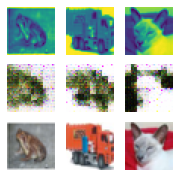

##############
Para época de número:1
Treinando o Discriminador
Treinando o Gerador
Perda do Discriminador:0.17020536950018506
Perda do Gerador:0.715365287065506


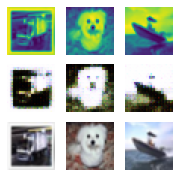

##############
Para época de número:2
Treinando o Discriminador
Treinando o Gerador
Perda do Discriminador:0.16983650232791023
Perda do Gerador:0.6903854734301567


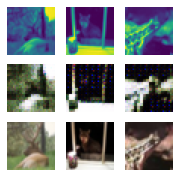

##############
Para época de número:3
Treinando o Discriminador
Treinando o Gerador
Perda do Discriminador:0.16682193249567445
Perda do Gerador:0.6813842078447342


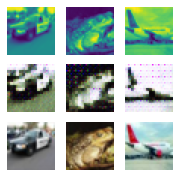

##############
Para época de número:4
Treinando o Discriminador


In [ ]:

for epoch in range(epochs):
  print("##############")
  print("Para época de número:"+str(epoch))

  g_loss = 0
  d_loss = 0

  print("Treinando o Discriminador")

  i = shuffle(range(n_example))

  dis.trainable = True
  dis.compile(loss = "binary_crossentropy",optimizer = adams)

  for j in range(dis_updates):

    for b in range(batches):

      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]

      pre_batch = gen.predict(x_batch)

      d_loss += dis.train_on_batch([x_batch,y_batch],one)
      d_loss += dis.train_on_batch([x_batch,pre_batch],zero)

  print("Treinando o Gerador")

  dis.trainable = False
  combined.compile(loss  = "binary_crossentropy", optimizer = adams)
  dis.compile(loss = "binary_crossentropy",optimizer = adams)

  for  j in range(gen_updates):

    for b in range(batches):

      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]


      # caso ocorra um colapso ... comentar as próximas duas linhas pode ajudar.
      #if b%4==3:
        #gl,_,_ = combined.train_on_batch([x_batch,y_batch],[zero,one])

      gl,_,_ = combined.train_on_batch([x_batch,y_batch],[one,one])
      g_loss += gl

  g_loss /= g_loss_factor
  d_loss /= d_loss_factor

  print("Perda do Discriminador:"+str(d_loss))
  print("Perda do Gerador:"+str(g_loss))

  genLoss.append(g_loss)
  disLoss.append(d_loss)

  gen.save_weights("Gerador.h5")
  dis.save_weights("Discriminador.h5")



  plt_indices = np.random.randint(50000,size=3)
  plt_a = x[plt_indices]
  plt_b = gen.predict(plt_a)
  plt_b = (plt_b+1)/2
  plt_c = (y[plt_indices]+1)/2
  fig = plot(plt_a,plt_b,plt_c,3)
  plt.show()
  plt.close(fig)



plt.plot(genLoss, c='r', label="Perda do Gerador")
plt.plot(disLoss, c='b', label="Perda do Discriminador")
plt.xlabel("Iterações")
plt.ylabel("Perda")
plt.legend()
plt.show()

files.download('Gerador.h5')
files.download('Discriminador.h5')